# Notebook to load and save grids of images

Includes spherical linear interpolation of images and nearest neighbours

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import utils as vutils
from torchvision import transforms
from torchvision.datasets import ImageFolder
import numpy as np
import os
import shutil
from PIL import Image
from models import Generator
from operation import load_params, get_config, H5Dataset
from metrics.metric_utils import truncated_z_sample, Batched_Normalize
import json
from glob import glob

from numpy_transforms import NumpyRandomFlip, NumpyToTensor
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\pylab\backend_inline.py:164: DeprecationWarning: `configure_inline_support` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.configure_inline_support()`
  configure_inline_support(ip, backend)


In [2]:
class CustomImageFolder(Dataset):
    from PIL import Image
    def __init__(self, root, transform=None):
        self.transform = transform
        self.root = root
        self.image_paths = glob(root+'/*.jpg') + glob(root+'/*.png')
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)
    

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
def sample_generator(netG, z, norm_stats=None):
    imgs = netG(z)[0]
    # convert images from -1 1 to 0 255 uint8 (as would be done if saving)
    imgs_convert = (imgs * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    # convert back to torch FloatTensor
    imgs_convert = imgs_convert.to(torch.float32).div_(255)
    # normalize
    if norm_stats is not None:
        imgs_convert = Batched_Normalize(imgs_convert, norm_stats['mean'], norm_stats['std'])
    return imgs.add(1).mul(0.5).to('cpu'), imgs_convert


C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def save_image_qual(tensor, fp, nrow=8, padding=2,
                   normalize=False, range=None, scale_each=False, pad_value=0, format=None, quality=None):
    """Save a given Tensor into an image file. Added functionality to save quality
    Args:
        tensor (Tensor or list): Image to be saved. If given a mini-batch tensor,
            saves the tensor as a grid of images by calling ``make_grid``.
        fp - A filename(string) or file object
        format(Optional):  If omitted, the format to use is determined from the filename extension.
            If a file object was used instead of a filename, this parameter should always be used.
        **kwargs: Other arguments are documented in ``make_grid``.
    """
    from PIL import Image
    grid = vutils.make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)
    im.save(fp, format=format, quality=quality)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Save a set of generated (uncurated) images

In [7]:
def save_generated(args_dict):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    target_gen = args_dict['target_gen']
    ckpts_use = args_dict['ckpts_use']
    batch_gen = args_dict['batch_gen']
    experiment_names = args_dict['experiment_names']
    ema = args_dict['ema']

    for experiment, ckpt_iter in zip(experiment_names, ckpts_use):
        folder_save = os.path.join(save_dir, experiment)
        os.makedirs(folder_save, exist_ok=True)
        
        ckpt_path = os.path.join(args_dict['base_dir'], experiment, 'models', f'all_{ckpt_iter}.pth')
        checkpoint=torch.load(ckpt_path)

        # load in the generator
        with open(os.path.join(base_dir,  experiment, 'args.txt'), mode='r') as f:
            args_train = json.load(f)
            model_config = args_train['model_config']
            model_config = get_config('model_configs.csv', model_config, type='model')
            noise_dim = model_config['nz']

            netG = Generator(
                    nz                  = model_config['nz'],
                    activation          = model_config['g_activation'],
                    chan_attn           = model_config['g_chan_attn'],
                    sle_map             = model_config['g_skip_map'],
                    skip_conn           = model_config['g_skip_conn'],
                    spatial_attn        = model_config['g_spatial_attn'],
                    attn_layers         = model_config['g_attn_layers'],
                    conv_layers         = model_config['g_conv_layers'],
                    alternate_layers    = model_config['g_alternate_layers'],
                    anti_alias          = model_config['g_anti_alias'],
                    noise_inj           = model_config['g_noise_inj'],
                    multi_res_out       = model_config['g_multi_res_out'],
                    small_im_size       = model_config['g_small_im_size'],
                    use_tanh            = model_config['use_tanh']
            )

            print('all ok!') 

        # load in parameters
        if ema:
            load_params(netG, checkpoint['g_ema'])
        else:
            load_params(netG, checkpoint['g'])

        netG.to(device)

        # generator warm-up
        print('warming up generator...')
        for i in range(100):
            z = truncated_z_sample(8, noise_dim, truncation=0).to(device)
            _,_ = sample_generator(netG, z, norm_stats=None)
        
        # generate samples
        generated = 0
        while generated < target_gen:
            z = truncated_z_sample(batch_gen, noise_dim, truncation=0).to(device)
            imgs_save,_ = sample_generator(netG, z, norm_stats=None)
            for img in imgs_save:
                imarr = img.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
                pil_img = Image.fromarray(imarr)
                pil_img.save(os.path.join(folder_save, f'{generated}.jpg'), quality=95)
                generated += 1
                if generated==target_gen:
                    break

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
base_dir = 'D:/ucl_masters_data/project/fastGAN_experiments/extended'
save_dir = './plots/generated'
experiment_names = ['cored_final', 'CAA_final', 'cored-diffuse_final', 'CAA-diffuse_final']
ckpts_use = [90000, 100000, 80000, 70000]
target_gen = 200
batch_gen = 8

args_dict = {'base_dir': base_dir,
            'experiment_names': experiment_names,
            'ckpts_use': ckpts_use,
            'target_gen': target_gen,
            'batch_gen': batch_gen, 
            'ema': True}

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
save_generated(args_dict)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


all ok!
warming up generator...
all ok!
warming up generator...
all ok!
warming up generator...
all ok!
warming up generator...


# Save grids of generated images

In [5]:
base_dir = 'D:/ucl_masters_data/project/fastGAN_experiments/extended'
save_dir = './plots/generated_grid'
experiment_names = ['cored_final', 'CAA_final', 'cored-diffuse_final', 'CAA-diffuse_final']
n_cols = 2
n_rows = 8

def save_generated(base_dir = base_dir, save_dir = save_dir, experiment_names = experiment_names,
                  n_rows = n_rows, n_cols = n_cols, n_repeats = 3):
    for experiment in experiment_names:
        folder_gen = os.path.join('./plots/generated', experiment)
        trans = transforms.Compose([transforms.ToTensor()])
        dataset = CustomImageFolder(root=folder_gen, transform = trans)
        dataloader = DataLoader(dataset, batch_size = (n_cols*n_rows), shuffle=True)
        for i in range(n_repeats):
            images = next(iter(dataloader))
            os.makedirs(os.path.join(save_dir, experiment), exist_ok=True)
            save_image_qual(images, os.path.join(save_dir, experiment,f'{experiment}_generated_{i}.jpg'), 
                            nrow=n_cols, quality=95)
#             vutils.save_image(images, os.path.join(save_dir, experiment,'rejected.jpg'), nrow=n_cols)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
save_generated(base_dir = base_dir, save_dir = save_dir, experiment_names = experiment_names,
                 n_rows = n_rows, n_cols = n_cols)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


200
200
200
200


# Save grids of rejected images

In [10]:
base_dir = 'D:/ucl_masters_data/project/fastGAN_experiments/extended'
save_dir = './plots/rejected'
experiment_names = ['cored_final', 'CAA_final', 'cored-diffuse_final', 'CAA-diffuse_final']
n_cols = 10
n_rows = 1
def save_rejects(base_dir = base_dir, save_dir = save_dir, experiment_names = experiment_names,
                 n_rows = n_rows, n_cols = n_cols):
    
    for experiment in experiment_names:
        folder_rejects = os.path.join(base_dir, experiment, 'rejected')
        trans = transforms.Compose([transforms.ToTensor()])
        dataset = ImageFolder(root=folder_rejects, transform = trans)
        dataloader = DataLoader(dataset, batch_size = (n_cols*n_rows), shuffle=True)
        images,_ = next(iter(dataloader))
        
        os.makedirs(os.path.join(save_dir, experiment), exist_ok=True)
        vutils.save_image(images, os.path.join(save_dir, experiment,'rejected.jpg'), nrow=n_cols)
    
  

In [11]:
save_rejects(base_dir = base_dir, save_dir = save_dir, experiment_names = experiment_names,
                 n_rows = n_rows, n_cols = n_cols)

# Save grid of LPIPS vs MSE

In [8]:
def images_2_grid(img_dir, save_dir, save_name = 'trial', n_rows = 2, n_cols = 2, n_repeats = 3):
    trans = transforms.Compose([transforms.ToTensor()])
    dataset = CustomImageFolder(root=img_dir, transform=trans)
    dataloader = DataLoader(dataset, batch_size = (n_cols*n_rows), shuffle=True)
    
    for repeat in range(n_repeats):
        images = next(iter(dataloader))
#         os.makedirs(os.path.join(save_dir, experiment), exist_ok=True)
        save_image_qual(images, os.path.join(save_dir,f'{save_name}_sampled_{repeat}.jpg'), 
                            nrow=n_cols, quality=95)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
img_dir = 'D:/ucl_masters_data/project/fastGAN_experiments/extended/model_base_train_A/evaluation/selected/accepted'
save_dir = 'C:/Users/ciara/Documents/ucl_masters/modules/Project/FastGAN-extended/plots/generated_grid'
save_name = 'lpips'
images_2_grid(img_dir=img_dir, save_dir=save_dir, save_name=save_name, n_rows=2, n_cols=2, n_repeats=5)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
img_dir = 'D:/ucl_masters_data/project/fastGAN_experiments/extended/fastgan_orig/fid/fake'
save_dir = 'C:/Users/ciara/Documents/ucl_masters/modules/Project/FastGAN-extended/plots/generated_grid'
save_name = 'mse'
images_2_grid(img_dir=img_dir, save_dir=save_dir, save_name=save_name, n_rows=2, n_cols=2, n_repeats=5)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
img_dir = 'D:/ucl_masters_data/project/fastGAN_experiments/extended/fastgan_orig/fid/real'
save_dir = 'C:/Users/ciara/Documents/ucl_masters/modules/Project/FastGAN-extended/plots/generated_grid'
save_name = 'real'
images_2_grid(img_dir=img_dir, save_dir=save_dir, save_name=save_name, n_rows=2, n_cols=2, n_repeats=5)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Save grids of slerp'd images

In [3]:
# linear interpolation
@torch.no_grad()
def lerp(netG, z1, z2, step=8):
    """ 
    Function to generate sequence of images from interpolation of two latent space vectors
    
    Params
    ------
    netG: Generator model
    z1: first latent vector
    z2: second latent vector
    step: number of interpolated images to generate
    save_dir: directory to save images to
    img_name: name to save the sequence of images
    ext: image format to use. 'jpg' or 'png' appropriate.
    
    Returns
    -------
    interp_images: The interpolated images
    z_interp: The sequence of interpolated latent vectors
    """
    netG.eval()
    alphas = torch.linspace(0, 1, steps=step)
    
    z_interp = [(1-alpha)*z1 + alpha*z2 for alpha in alphas]
    # rearrange into a batch that can be passed through the generator
    z_interp = torch.cat(z_interp).view(step,-1)
    interp_images,_ = sample_generator(netG, z_interp)
    
    return interp_images

@torch.no_grad()
def slerp_calc_single(val, low, high):
    low_norm = low/torch.norm(low)
    high_norm = high/torch.norm(high)
    omega = torch.acos(low_norm*high_norm)
    so = torch.sin(omega)
    res = (torch.sin((1.0-val)*omega)/so)*low + (torch.sin(val*omega)/so)*high
    return res

# spherical interpolation - better when noise is sampled from a hypersphere rather than hypercube
@torch.no_grad()
def slerp(netG, z1, z2, step=8):
    alphas = torch.linspace(0, 1, steps=step)
    z_interp = [slerp_calc_single(alpha,z1,z2) for alpha in alphas]
    # rearrange into a batch that can be passed through the generator
    z_interp = torch.cat(z_interp).view(step,-1)
#     interp_images = netG(z_interp)[0]
    interp_images,_ = sample_generator(netG, z_interp)
#     save_path = os.path.join(save_dir, f'{img_name}.{ext}')
#     vutils.save_image(interp_images.add(1).mul(0.5), save_path, nrow=step)
    
    return interp_images

# @torch.no_grad()
# def slerp(netG, z1, z2, step=8, save_dir ='.', img_name='interpolation', ext='jpg'):
#     alphas = torch.linspace(0, 1, steps=step)
#     z_interp = [slerp_calc_single(alpha,z1,z2) for alpha in alphas]
#     # rearrange into a batch that can be passed through the generator
#     z_interp = torch.cat(z_interp).view(step,-1)
#     interp_images = netG(z_interp)[0]
#     save_path = os.path.join(save_dir, f'{img_name}.{ext}')
#     vutils.save_image(interp_images.add(1).mul(0.5), save_path, nrow=step)
    
#     return interp_images, z_interp



C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# sample from checkpoints and save a number of interpolated examples
@torch.no_grad()
def save_slerp(args_dict):
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    n_samples = args_dict['n_samples']
    n_steps = args_dict['n_steps']
    n_rows = args_dict['n_rows']
    ckpts_use = args_dict['ckpts_use']
    
    experiment_names = args_dict['experiment_names']
    ema = args_dict['ema']
    run_slerp = args_dict['slerp']
    for experiment, ckpt_iter in zip(experiment_names, ckpts_use):
        save_dir = './plots/slerp'
        ckpt_path = os.path.join(args_dict['base_dir'], experiment, 'models', f'all_{ckpt_iter}.pth')
        checkpoint=torch.load(ckpt_path)

        # load in the generator
        with open(os.path.join(base_dir,  experiment, 'args.txt'), mode='r') as f:
            args_train = json.load(f)
            model_config = args_train['model_config']
            model_config = get_config('model_configs_final.csv', model_config, type='model')
            noise_dim = model_config['nz']

            netG = Generator(
                    nz                  = model_config['nz'],
                    activation          = model_config['g_activation'],
                    chan_attn           = model_config['g_chan_attn'],
                    sle_map             = model_config['g_skip_map'],
                    skip_conn           = model_config['g_skip_conn'],
                    spatial_attn        = model_config['g_spatial_attn'],
                    attn_layers         = model_config['g_attn_layers'],
                    conv_layers         = model_config['g_conv_layers'],
                    alternate_layers    = model_config['g_alternate_layers'],
                    anti_alias          = model_config['g_anti_alias'],
                    noise_inj           = model_config['g_noise_inj'],
                    multi_res_out       = model_config['g_multi_res_out'],
                    small_im_size       = model_config['g_small_im_size'],
                    use_tanh            = model_config['use_tanh']
            )

            print('all ok!') 

        # load in parameters
        if ema:
            load_params(netG, checkpoint['g_ema'])
        else:
            load_params(netG, checkpoint['g'])

        netG.to(device)

        # generator warm-up
        print('warming up generator...')
        for i in range(100):
            z = truncated_z_sample(8, noise_dim, truncation=0).to(device)
            _,_ = sample_generator(netG, z, norm_stats=None)
        
        # now do the interpolations
        for j in range(n_samples):
            z1_all = truncated_z_sample(n_rows, noise_dim, truncation=0).to(device)
            z2_all = truncated_z_sample(n_rows, noise_dim, truncation=0).to(device)
            
            images_all = []
            for z1,z2 in zip(z1_all, z2_all):
                if run_slerp:
                    images_all.append(slerp(netG, z1, z2, step=n_steps))
                else:
                    images_all.append(lerp(netG, z1, z2, step=n_steps))
            
            images_all = torch.cat(images_all)
            
            #save the images
            if run_slerp:
                vutils.save_image(images_all, os.path.join(save_dir, f'{experiment}_slerp_{j}.jpg'), nrow=n_steps)
            else:
                vutils.save_image(images_all, os.path.join(save_dir, f'{experiment}_lerp_{j}.jpg'), nrow=n_steps)
    

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
base_dir = 'D:/ucl_masters_data/project/fastGAN_experiments/extended'
experiment_names = ['cored_final', 'CAA_final', 'cored-diffuse_final', 'CAA-diffuse_final']
ckpts_use = [90000, 100000, 80000, 70000]
n_samples = 30
n_steps = 10
n_rows = 1

args_dict = {'base_dir': base_dir,
            'experiment_names': experiment_names,
            'ckpts_use': ckpts_use,
            'n_samples': n_samples,
            'n_steps': n_steps,
            'n_rows': n_rows,
            'ema': True,
            'slerp': True}

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
save_slerp(args_dict)

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


all ok!
warming up generator...
all ok!
warming up generator...
all ok!
warming up generator...
all ok!
warming up generator...


# K Nearest Neighbours

In [5]:
import h5py
import lpips

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
@torch.no_grad()
def get_top_nn_lpips(generated_folder, hdf5_real, percept, top_k=5, n_show = 8, n_repeats = 5,
                     save_path=None, experiment_name = None):
    """
    Calculate the LPIPS distance metric between a set of synthesised and real images.
    Save all computed distances between fake and real samples in another hdf5 file (?) for easy retrieval
    Also displays and saves the top k real images against the synthesised images
    """
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    transform_list_real = [NumpyToTensor(),
                        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
                        ]
    
    transform_list_fake = [transforms.ToTensor(),
                          transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
                          ]
    
    trans_real = transforms.Compose(transform_list_real)
    trans_fake = transforms.Compose(transform_list_fake)
    
    fake_dataset = CustomImageFolder(generated_folder, transform=trans_fake)
    real_dataset = H5Dataset(file_path=hdf5_real, transform=trans_real)
    
    fake_dataloader = DataLoader(fake_dataset, batch_size=n_show, shuffle=True, num_workers=0)
    batch_size_real = 16
    real_dataloader = DataLoader(real_dataset, batch_size=batch_size_real, shuffle=False, num_workers=0)
    
    # initialise array to store the perceptual distances between samples
    
    iter_fake_dataloader = iter(fake_dataloader)
    
    for n_repeat in tqdm(range(n_repeats), total = n_repeats):
        # initialise array to store the perceptual distances between samples
        dists = torch.zeros((n_show, len(real_dataset)))
        fake_imgs = next(iter_fake_dataloader)
        # cycle through each fake image
        for i, fake_img in enumerate(fake_imgs):
            fake_img = fake_img.to(device)
            for j, real_imgs in enumerate(real_dataloader):
                real_imgs = real_imgs.to(device)
                dist = percept(fake_img, real_imgs).squeeze().cpu()
                idx_start = j*batch_size_real
                dists[i, idx_start:idx_start+len(dist)] = dist
            
        # find nearest neighbours to the fake images
        vals, idx_nn = torch.topk(dists, top_k, largest=False)
        # find furthest neighbours to the fake images (if desired)
        vals_f, idx_fn = torch.topk(dists, top_k, largest=True)
        
        # generate the grid of images to be saved
        channels, height, width = real_imgs.shape[1:]
        # padding (in pixels) between fake and real images
        pad = 10
        grid = np.zeros((n_show*height, (top_k+1)*width + pad, channels))
        neighbours = dict()
        
        for i, fake_img in enumerate(fake_imgs):
            total = fake_img.permute(1, 2, 0).numpy()
            # add on the padding
            padded = -1*np.ones((height, pad, channels))
            total = np.concatenate([total, padded], axis=1)
            neighbours[i] = list()
            for j in range(top_k):
                neighbours[i].append((idx_nn[i,j], vals[i,j]))
                real = real_dataset[idx_nn[i,j]].permute(1, 2, 0).numpy()
                total = np.concatenate([total, real], axis=1)
                
            # fill in the grid
            grid[i*height:(i+1)*height, :, :] = total
        
        # recast grid to correct range for saving.
        grid = (grid + 1) * 0.5
        plt.imshow(grid)
        
        # save the grid
        if save_path is not None:
            plt.imsave(os.path.join(save_path,f'{experiment_name}_nn_{n_repeat}.jpg'), grid)
        

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
def save_nn(args_dict):
    experiment_names = args_dict['experiment_names']
    top_k = args_dict['top_k']
    n_repeats = args_dict['n_repeats']
    n_show = args_dict['n_show']
    save_path = args_dict['save_path']
    
    percept = lpips.PerceptualLoss(model='net-lin', net='vgg', use_gpu=True)
    
    hdf5_paths = ['../FastGAN-pytorch-main/data/hdf5/cored/hdf5_cored_train_images.h5',
                '../FastGAN-pytorch-main/data/hdf5/CAA/hdf5_CAA_train_images.h5',
                '../FastGAN-pytorch-main/data/hdf5/cored-diffuse/hdf5_cored-diffuse_train_images.h5',
                '../FastGAN-pytorch-main/data/hdf5/CAA-diffuse/hdf5_CAA-diffuse_train_images.h5']
    
    for experiment, hdf5_real in zip(experiment_names, hdf5_paths):
        generated_folder = os.path.join('./plots/generated', experiment)
        
        get_top_nn_lpips(generated_folder, hdf5_real, percept, top_k=top_k, n_show = n_show, n_repeats = n_repeats,
                     save_path=save_path, experiment_name = experiment)
    

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
experiment_names = ['cored_final', 'CAA_final', 'cored-diffuse_final', 'CAA-diffuse_final']
top_k = 4
n_repeats = 5
n_show = 5
save_path = './plots/nn'
args_dict = {'experiment_names': experiment_names,
            'top_k': top_k,
            'n_repeats': n_repeats,
            'n_show': n_show,
            'save_path': save_path}

C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Setting up Perceptual loss...
Loading model from: C:\Users\ciara\Documents\ucl_masters\modules\Project\FastGAN-extended\lpips\weights\v0.1\vgg.pth


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

...[net-lin [vgg]] initialized
...Done


C:\Users\ciara\anaconda3\envs\thesis\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:39<00:00, 31.97s/it]


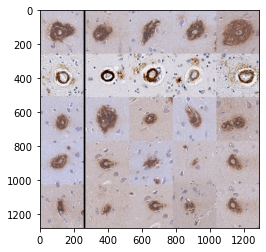

In [9]:
save_nn(args_dict)